# Neural Network for CIFAR10 Classification
In this assignment, we will further enhance our CIFAR10 classifier implementation by some techniques to increase its accuracy.

## Data Preparation and Visualization

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import sys
# sys.path.append('/content/drive/MyDrive/HW5/')
sys.path.append('./')

In [3]:
# You may change `MODEL_DIR` to a existing local directory if you are not using Colab
MODEL_DIR = './'
MODEL_PATH = MODEL_DIR + 'model.pt' if MODEL_DIR.endswith('/') else MODEL_DIR + '/model.pt'

In [4]:
from _utils import load_data, Dataset, Dataloader, plot_curves, plot_result
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

In [5]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
  print(f'Using torch {torch.__version__}, device = {torch.cuda.get_device_name(0)}')
else:
  DEVICE = 'cpu'
  print(f'Using torch {torch.__version__}, device = cpu')

Using torch 2.0.0+cu117, device = GeForce GTX 1050


In [6]:
images, labels, classes = load_data()

Files already downloaded and verified


In [7]:
print(f'Data type of images: {images.dtype} (value range: [{images.min()}, {images.max()}])')
print(f'Shape of images: {images.shape}')
print(f'Shape of labels: {labels.shape}')
print(f'Number of classes: {len(classes)}')
print(f'Classes: {classes}')

Data type of images: uint8 (value range: [0, 255])
Shape of images: (50000, 32, 32, 3)
Shape of labels: (50000,)
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


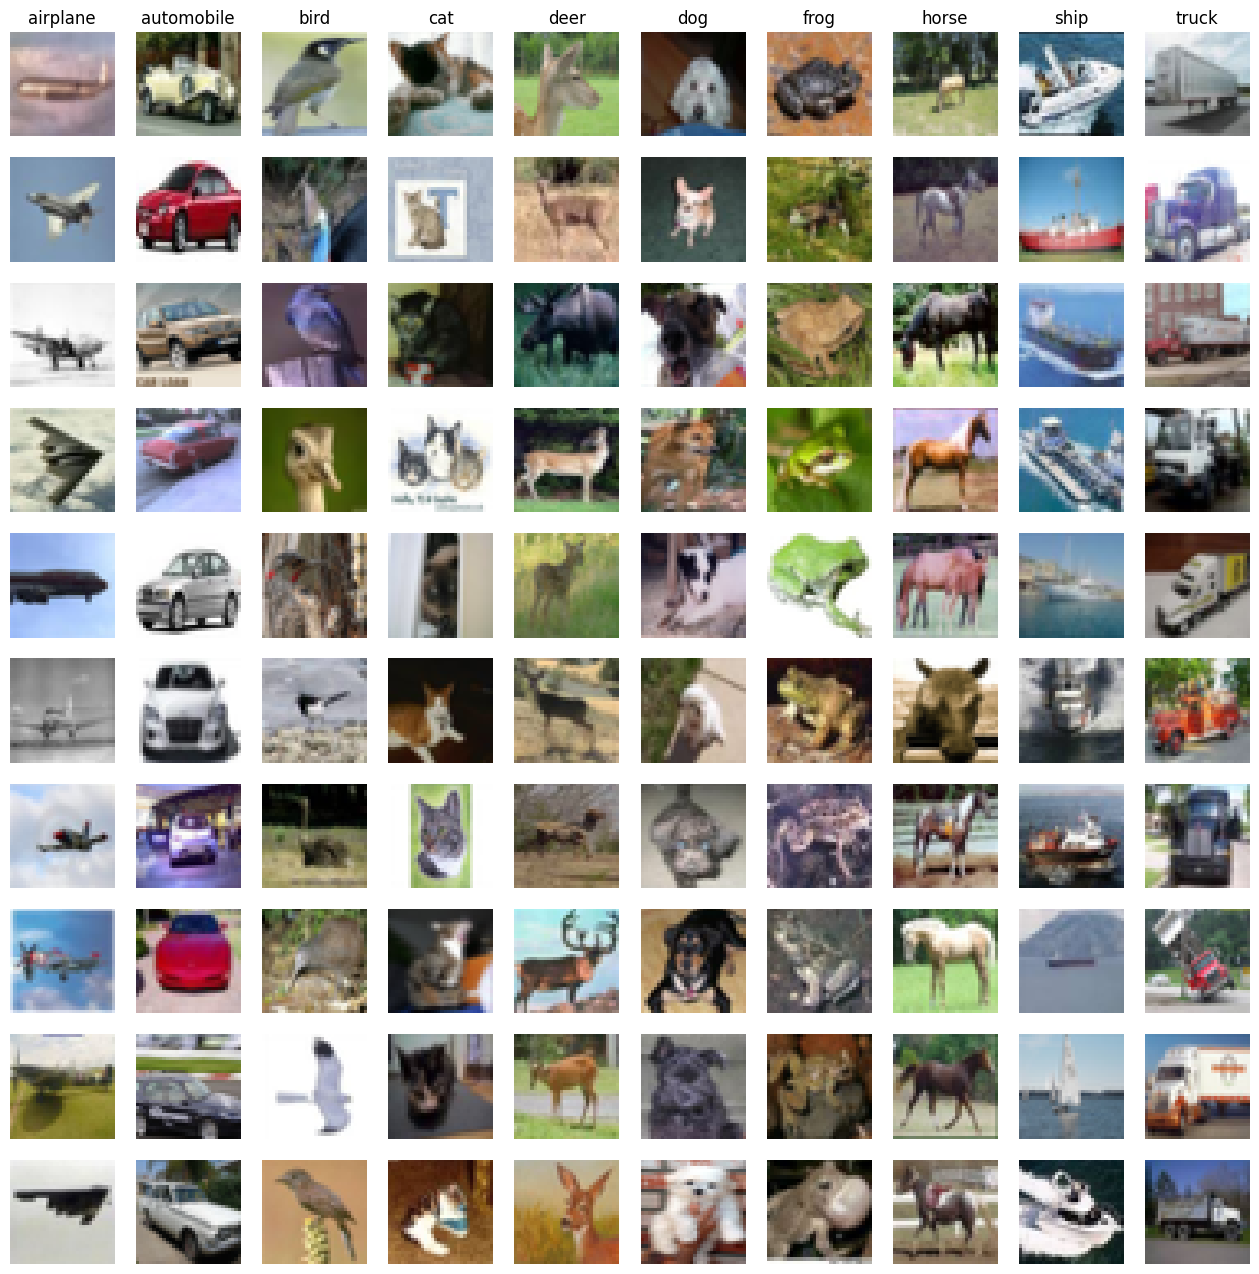

In [8]:
# Display samples of each class
plt.rcParams['figure.figsize'] = (16, 16)
num_classes = len(classes)
num_example = 10
for label, class_name in enumerate(classes):
  idxs = np.flatnonzero(labels == label)
  idxs = np.random.choice(idxs, num_example, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * num_classes + label + 1
    plt.subplot(num_example, num_classes, plt_idx)
    plt.imshow(images[idx]); plt.axis('off')
    if i == 0:
      plt.title(class_name)
plt.show()

In [9]:
# Data splitting with numpy array slicing
num_data = images.shape[0]
split_ratio = {'train': 0.6, 'valid': 0.2, 'test': 0.2}
num_valid_data = round(num_data * split_ratio['valid'])
num_test_data = round(num_data * split_ratio['test'])
num_train_data = num_data - (num_valid_data + num_test_data)

start_idx = 0
train_dataset = Dataset(images[start_idx:start_idx+num_train_data], labels[start_idx:start_idx+num_train_data])
start_idx += num_train_data

valid_dataset = Dataset(images[start_idx:start_idx+num_valid_data], labels[start_idx:start_idx+num_valid_data])
start_idx += num_valid_data

test_dataset = Dataset(images[start_idx:start_idx+num_test_data], labels[start_idx:start_idx+num_test_data])

print(f'Number of training data: {len(train_dataset)}')
print(f'Number of validation data: {len(valid_dataset)}')
print(f'Number of test data: {len(test_dataset)}')

Number of training data: 30000
Number of validation data: 10000
Number of test data: 10000


In [10]:
# Configurations
data, label = train_dataset[0]
IN_DIM = data.shape[0]
OUT_DIM = len(classes)

## Layer Definition
The architecture of a two-layer fully-connected neural network is like:

Input $\rightarrow$ Fully-Connected Layer1 $\rightarrow$ ReLU  $\rightarrow$ Fully-Connected Layer2 $\rightarrow$ Softmax

The learnable parameters are weights and bias of the two fully-connected layers. Let's name and clarify the parameters and their shapes:

1. Input data: $\mathbf{x}$, shape: ${N\times D}$
2. Weights of first fully-connected layer: $\mathbf{w_1}$, shape: ${D\times H}$
3. Bias of first fully-connected layer: $\mathbf{b_1}$, shape: ${H}$
4. Weights of second fully-connected layer: $\mathbf{w_2}$, shape: ${H\times C}$
5. Bias of second fully-connected layer: $\mathbf{b_2}$, shape: ${C}$
6. Output of the network: $\mathbf{S}$, shape: ${N\times C}$

And then we can simply express the function the network by:
$$\mathbf{S} = \mathbf{w_2} * ReLU(\mathbf{w_1} * \mathbf{x} + \mathbf{b_1}) + \mathbf{b_2}$$

Since the two fully-connected layers do the same job, that is, multiply weights with input and then plus bias, we define a class called FullyConnectedLayer to implement a single fully-connected layer.

In [11]:
class FullyConnectedLayer(object):
  def __init__(self, device='cpu'):
    self.dv = device
  def __name__(self):
    return 'FullyConnectedLayer'
  def forward(self, x, w, b):
    N, D = x.shape # (batch_size, input_size)
    Dw, F = w.shape # (input_size, output_size)
    assert Dw == D, f'Wrong shape of weights, expected ({D},{F}) but got ({Dw},{F})'
    Fb = b.shape[0]
    assert Fb == F, f'Wrong shape of bias, expected ({F},) but got ({Fb},)'
    out = torch.zeros((N, F)).to(self.dv)
    ####################
    # TODO:
    # 1. Implement fully connected layer with `w` * `x` + `b` and store the result in variable `out`
    ####################
    # -----START OF YOUR CODE-----
    
    out = torch.matmul(x, w) + b #(batch_size, output_size)

    # ------END OF YOUR CODE------
    self.cache = (x, w, b, out)
    return out
  def backward(self, backprop):
    N, F = backprop.shape

    dx = None
    dw = None
    db = None
    ####################
    # TODO:
    # 1. Derive the gradient of bias, i.e., d(out)/d(b)
    # 2. Multiply d(out)/d(b) with `backprop` due to chain rule, and then store the AVERAGED result in variable `db`
    # 3. Then, derive the gradient of weights, i.e., d(out)/d(w)
    # 4. Multiply d(out)/d(w) with `backprop` due to chain rule, and then store the AVERAGED result in variable `dw`
    # 5. Finally, derive the gradient of the input, i.e., d(out)/d(x)
    # 6. Multiply d(out)/d(x) with `backprop` due to chain rule, and then store the result in variable `dx`
    # HINT: Shapes of `db`, `dw` and `dx` should be (F,), (D, F) and (N, D) respectively
    ####################
    # -----START OF YOUR CODE-----
    dw = torch.matmul(self.cache[0].transpose(0, 1) , backprop) / self.cache[0].shape[0]

    db = torch.mean(backprop , axis=0, keepdim=False)

    dx = torch.matmul(backprop, self.cache[1].transpose(0, 1))

    # ------END OF YOUR CODE------
    return dx, dw, db

In [12]:
from _utils import FCL_Tests

layer = FullyConnectedLayer()
FCL_Tests(layer)

Results of fully connected layer forward and backward tests: All passed.


ReLU (Rectified Linear Unit) is the currently most used non-linearity (or called activation function) in neural networks. Its formula as following:
$$ReLU(t) = max(0, t)$$

Since ReLU only allows positive values to be passed forward, any negative values of the input will not be able to propagate gradients during backpropagation.

In [13]:
class ReLU(object):
  def __init__(self):
    pass
  def __name__(self):
    return 'ReLU'
  def forward(self, t):
    out = t.clone()
    ####################
    # TODO:
    # 1. Implement ReLU on `t` and store in variable `out`
    ####################
    # -----START OF YOUR CODE-----

    out = torch.maximum(torch.zeros_like(out), out)
    
    # ------END OF YOUR CODE------
    self.cache = (t, out)
    return out
  def backward(self, backprop):
    dt = torch.zeros_like(backprop)
    ####################
    # TODO:
    # 1. Derive d(out)/d(t)
    # 2. Multiply d(out)/d(t) with `backprop` due to chain rule, and then store the result in variable `dt`
    ####################
    # -----START OF YOUR CODE-----
    dt = self.cache[1]
    dt[dt > 0] = 1
    dt = dt.mul(backprop)
    # ------END OF YOUR CODE------
    return dt

In [14]:
from _utils import ReLU_Tests

layer = ReLU()
ReLU_Tests(layer)

Results of ReLU function tests: All passed.


Softmax is used to convert a vector of real numbers into a probability distribution over classes. It can be expressed mathematically as:
$$softmax(\mathbf{S}_i)=\mathbf{p}_i=\frac{exp(\mathbf{S}_i)}{\sum_{j=1}^\mathbf{C}exp(\mathbf{S}_j)}$$
And the cross-entropy loss, on the other hand, is a measure of the difference between the predicted probability distribution and the true probability distribution of the labels. Let $\mathbf{y}$ be **one-hot encoded** ground-truth label, that is, its shape would be the same with output of the network. Cross-entropy loss formula is defined as:
$$CE = -\sum\mathbf{y}_i * log(\mathbf{p}_i)$$

In [15]:
class Softmax_CrossEntropy(object):
  def __init__(self):
    pass
  def forward(self, y, net_out):
    N, F = net_out.shape
    prob = torch.zeros_like(net_out)
    ####################
    # TODO:
    # 1. Implement Softmax and store the result in variable `prob`
    # HINT: Shape of `prob` should be (N, F)
    ####################
    # -----START OF YOUR CODE-----

    # Subtract the maximum logit to improve numerical stability
    # exp_logits: matrix of shape (batch_size, num_classes)
    exp_logits = torch.exp(net_out - torch.max(net_out, axis=1, keepdims=True)[0])
    # Compute the softmax probabilities
    # softmax_probs: matrix of shape (batch_size, num_classes)    
    softmax_probs = exp_logits / torch.sum(exp_logits, axis=1, keepdims=True)
    prob = softmax_probs
    
    # ------END OF YOUR CODE------
    self.cache = (y, prob)
    pred_y = prob.argmax(dim=1)
    
    y_one_hot = torch.zeros_like(net_out)
    y_one_hot[np.arange(N), y] = 1
    loss = torch.zeros(1)
    ####################
    # TODO:
    # 1. Implement cross-entropy loss and store the result in variable `loss`
    ####################
    # -----START OF YOUR CODE-----

    loss = -torch.mean(torch.sum(y_one_hot * torch.log(prob), axis=1))

    # ------END OF YOUR CODE------
    return pred_y, loss
  def backward(self):
    y, grad = self.cache
    N, F = grad.shape
    ####################
    # TODO:
    # 1. Derive the gradient of `net_out` and store the result in variable `grad`
    ####################
    # -----START OF YOUR CODE-----

    # Compute the gradient of the cross-entropy loss with respect to the logits
    # logits_grad: matrix of shape (batch_size, num_classes)
    y_one_hot = torch.zeros_like(grad)
    y_one_hot[np.arange(N), y] = 1
    grad = (grad - y_one_hot) / y_one_hot.shape[0]
    
    # ------END OF YOUR CODE------
    return grad

In [16]:
from _utils import SCE_Tests

layer = Softmax_CrossEntropy()
SCE_Tests(layer)

Results of softmax and cross entropy forward and backward tests: All passed.


We will bulid a four-layer fully-connected neural network and check shapes of each parameter.

In [17]:
from _utils import Network_Test

def test_classifier(x, y, dim_in, dim_out, dim_hidden):
  assert isinstance(dim_hidden, list), 'Parameter dim_hidden should be a list'
  np.random.seed(0)
  dim_hidden.append(dim_out)
  fc_i = 1
  params = {f'w{fc_i}': torch.from_numpy(np.random.randn(dim_in, dim_hidden[0])*0.8),
        f'b{fc_i}': torch.zeros(dim_hidden[0])}
  net = [FullyConnectedLayer()]
  for layer_i in range(len(dim_hidden)-1):
    fc_i += 1
    params[f'w{fc_i}'] = torch.from_numpy(np.random.randn(dim_hidden[layer_i], dim_hidden[layer_i + 1])*0.8)
    params[f'b{fc_i}'] = torch.zeros(dim_hidden[layer_i + 1])
    net.append(ReLU())
    net.append(FullyConnectedLayer())
  loss_func = Softmax_CrossEntropy()

  print('Network architecture and shapes of parameters:')
  fc_i = 1
  layer_out = net[0].forward(x, params[f'w{fc_i}'], params[f'b{fc_i}'])
  print(f'  {net[0].__name__()}: w1({params[f"w{fc_i}"].shape}), b1({params[f"b{fc_i}"].shape})')
  for layer_i in range(1, len(net), 2):
    # ReLU
    layer_out = net[layer_i].forward(layer_out)
    print(f'  {net[layer_i].__name__()}')
    # FullyConnectedLayer
    fc_i += 1
    layer_out = net[layer_i + 1].forward(layer_out, params[f'w{fc_i}'], params[f'b{fc_i}'])
    print(f'  {net[layer_i + 1].__name__()}: w{fc_i}({params[f"w{fc_i}"].shape}), b{fc_i}({params[f"b{fc_i}"].shape})')
  _, loss = loss_func.forward(y, layer_out)
  
  params_grad = {}
  dout = loss_func.backward()
  dout_dx, dout_dw, dout_db = net[len(net) - 1].backward(dout)
  params_grad[f'w{fc_i}'] = dout_dw; params_grad[f'b{fc_i}'] = dout_db
  for layer_i in range(len(net)-2, 0, -2):
    # ReLU
    dout = net[layer_i].backward(dout_dx)
    # FullyConnectedLayer
    fc_i -= 1
    dout_dx, dout_dw, dout_db = net[layer_i - 1].backward(dout)
    params_grad[f'w{fc_i}'] = dout_dw; params_grad[f'b{fc_i}'] = dout_db
  Network_Test(params, params_grad)

dim_in = 5; dim_out = 3
dim_hidden = [8, 4, 2]

np.random.seed(0)
x = torch.from_numpy(np.random.randn(2, dim_in))
y = np.array([0, 1])
test_classifier(x, y, dim_in, dim_out, dim_hidden)

Network architecture and shapes of parameters:
  FullyConnectedLayer: w1(torch.Size([5, 8])), b1(torch.Size([8]))
  ReLU
  FullyConnectedLayer: w2(torch.Size([8, 4])), b2(torch.Size([4]))
  ReLU
  FullyConnectedLayer: w3(torch.Size([4, 2])), b3(torch.Size([2]))
  ReLU
  FullyConnectedLayer: w4(torch.Size([2, 3])), b4(torch.Size([3]))
Test of network: Passed.


## Optimizer
Update weights with SGD:
$$\mathbf{W}\leftarrow\mathbf{W}-\eta\frac{\partial\mathbf{L}}{\partial\mathbf{W}}$$

In [18]:
class SGD(object):
  def __init__(self, learning_rate=1e-3):
    self.lr = learning_rate
  def step(self, params, params_grad):
    for key, val in params.items():
      if key not in params_grad.keys():
        raise KeyError(f'params_grad[\'{key}\'] is missing')
      if val.shape != params_grad[key].shape:
        raise ValueError(f'Expected shape of params_grad[\'{key}\'] {params[key].shape} but got {params_grad[key].shape}')
      ####################
      # TODO:
      # 1. Update each parameter `params[key]` with its gradient `params_grad[key]`
      ####################
      # -----START OF YOUR CODE-----
      
      params[key] -= self.lr * params_grad[key]

      # ------END OF YOUR CODE------

In [19]:
from _utils import SGD_Test

optimizer = SGD()
SGD_Test(optimizer)

Test of SGD: Passed.


Update weights with SGD+momentum:
$$v_t\leftarrow{m}v_{t-1}-\eta\frac{\partial\mathbf{L}}{\partial\mathbf{W}}$$
$$\mathbf{W}\leftarrow\mathbf{W}+v_t$$

In [20]:
class SGD_Momentum(object):
  def __init__(self, learning_rate=1e-3, momentum=0.9):
    self.lr = learning_rate
    self.momentum = momentum
    self.velocity = {}
  def step(self, params, params_grad):
    for key, val in params.items():
      if key not in params_grad.keys():
        raise KeyError(f'params_grad[\'{key}\'] is missing')
      if val.shape != params_grad[key].shape:
        raise ValueError(f'Expected shape of params_grad[\'{key}\'] {params[key].shape} but got {params_grad[key].shape}')
      if key not in self.velocity.keys():
        self.velocity[key] = torch.zeros_like(params[key])
      ####################
      # TODO:
      # 1. Update each velocity `self.velocity[key]` of each parameter
      # 2. Update each parameter `params[key]` with its velocity
      ####################
      # -----START OF YOUR CODE-----

      self.velocity[key] = self.momentum * self.velocity[key] - self.lr * params_grad[key]
      params[key] = params[key] + self.velocity[key]
      
      # ------END OF YOUR CODE------

In [21]:
from _utils import SGDM_Test

optimizer = SGD_Momentum()
SGDM_Test(optimizer)

Test of SGD_Momentum: Passed.


Update weights with Adam:
$$m_t\leftarrow\beta_1m_{t-1}+(1-\beta_1)\frac{\partial\mathbf{L_t}}{\partial\mathbf{W_t}}$$
$$v_t\leftarrow\beta_2v_{t-1}+(1-\beta_2)(\frac{\partial\mathbf{L_t}}{\partial\mathbf{W_t}})^2$$
$$\hat{m_t}=\frac{m_t}{1-\beta_1^t}$$
$$\hat{v_t}=\frac{v_t}{1-\beta_2^t}$$
$$\mathbf{W}\leftarrow\mathbf{W}-\eta\frac{\hat{m_t}}{\sqrt{\hat{v_t}}+\epsilon}$$

In [22]:
class Adam(object):
  def __init__(self, learning_rate=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.lr = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.momentum = {}
    self.velocity = {}
    self.t = 0
  def step(self, params, params_grad):
    self.t += 1
    for key, val in params.items():
      if key not in params_grad.keys():
        raise KeyError(f'params_grad[\'{key}\'] is missing')
      if val.shape != params_grad[key].shape:
        raise ValueError(f'Expected shape of params_grad[\'{key}\'] {params[key].shape} but got {params_grad[key].shape}')
      if key not in self.momentum.keys():
        self.momentum[key] = torch.zeros_like(params[key])
      if key not in self.velocity.keys():
        self.velocity[key] = torch.zeros_like(params[key])
      ####################
      # TODO:
      # 1. Update each momentum `self.momentum[key]` and velocity `self.velocity[key]` of each parameter
      # 2. Calculate the bias-corrected momentum and velocity, this step should NOT change the value in `self.momentum` nor `self.velocity`
      # 3. Update each parameter `params[key]` with its bias-corrected momentum and velocity
      ####################
      # -----START OF YOUR CODE-----
      self.momentum[key] = self.beta1 * self.momentum[key] + ( 1 - self.beta1 ) * params_grad[key]
      self.velocity[key] = self.beta2 * self.velocity[key] + ( 1 - self.beta2 ) * torch.square(params_grad[key])
      momentum_unbias = self.momentum[key] / (1 - self.beta1 ** self.t)
      velocity_unbias = self.velocity[key] / (1 - self.beta2 ** self.t)
      params[key] = params[key] - self.lr * (momentum_unbias / (torch.sqrt(velocity_unbias) + 1e-7))
      # ------END OF YOUR CODE------

In [23]:
from _utils import Adam_Test

optimizer = Adam()
Adam_Test(optimizer)

Test of Adam: Passed.


## Network Definition

In [24]:
class Classifier(object):
  def __init__(self, dim_in, dim_out, dim_hidden, device='cpu'):
    self.dv = device
    np.random.seed(0)
    assert isinstance(dim_hidden, list), 'Parameter dim_hidden shold be a list'
    dim_hidden.append(dim_out)
    fc_i = 1
    self.params = {f'w{fc_i}': torch.from_numpy(np.random.randn(dim_in, dim_hidden[0])*0.2).to(self.dv),
             f'b{fc_i}': torch.zeros(dim_hidden[0]).to(self.dv)}
    self.net = [FullyConnectedLayer(device=self.dv)]
    for layer_i in range(len(dim_hidden)-1):
      fc_i += 1
      self.params[f'w{fc_i}'] = torch.from_numpy(np.random.randn(dim_hidden[layer_i], dim_hidden[layer_i + 1])*0.2).to(self.dv)
      self.params[f'b{fc_i}'] = torch.zeros(dim_hidden[layer_i + 1]).to(self.dv)
      self.net.append(ReLU())
      self.net.append(FullyConnectedLayer(device=self.dv))
    self.loss_func = Softmax_CrossEntropy()
  def save_model(self, path):
    torch.save(self.params, path)
  def load_model(self, path):
    checkpoint = torch.load(path, map_location=self.dv)
    self.params = checkpoint
  def print_param_shape(self):
    for key, val in self.params.items():
      print(key, val.shape)
  def training(self, train_dataloader, valid_dataloader, optimizer, epochs=200, reg_lambda=0.0, verbose=1):
    train_loss_log = []
    train_acc_log = []
    valid_loss_log = []
    valid_acc_log = []
    best_val_loss = None
    for epoch in range(epochs):
      if (epoch+1) % verbose == 0:
        print(f'Epoch {epoch+1}:')
      single_epoch_log = ''
      train_loss = 0.0
      train_corr = 0.0; train_eval = 0.0
      for batch_idx in range(len(train_dataloader)):
        ### Model Input and Loss Calculation ###
        batch_data = train_dataloader[batch_idx]
        batch_img, batch_label = batch_data
        fc_i = 1
        layer_out = self.net[0].forward(torch.from_numpy(batch_img).to(self.dv), self.params[f'w{fc_i}'], self.params[f'b{fc_i}'])
        for layer_i in range(1, len(self.net), 2):
          # ReLU
          layer_out = self.net[layer_i].forward(layer_out)
          # FullyConnectedLayer
          fc_i += 1
          layer_out = self.net[layer_i + 1].forward(layer_out, self.params[f'w{fc_i}'], self.params[f'b{fc_i}'])
        pred_y, loss = self.loss_func.forward(batch_label, layer_out)
        for key, val in self.params.items(): # L2 regularization
          if key.startswith('w'):
            loss += reg_lambda * torch.sum(val * val)
        train_loss += loss.cpu().numpy()
        train_corr += torch.count_nonzero(pred_y == torch.from_numpy(batch_label).to(self.dv)).cpu().numpy()
        train_eval += batch_img.shape[0]

        ### Backpropagation and Optimization ###
        params_grad = {}
        dout = self.loss_func.backward()
        dout_dx, dout_dw, dout_db = self.net[len(self.net)-1].backward(dout)
        params_grad[f'w{fc_i}'] = dout_dw; params_grad[f'b{fc_i}'] = dout_db
        params_grad[f'w{fc_i}'] += 2 * reg_lambda * self.params[f'w{fc_i}']
        for layer_i in range(len(self.net)-2, 0, -2):
          # ReLU
          dout = self.net[layer_i].backward(dout_dx)
          # FullyConnectedLayer
          fc_i -= 1
          dout_dx, dout_dw, dout_db = self.net[layer_i - 1].backward(dout)
          params_grad[f'w{fc_i}'] = dout_dw; params_grad[f'b{fc_i}'] = dout_db
          params_grad[f'w{fc_i}'] += 2 * reg_lambda * self.params[f'w{fc_i}']
        optimizer.step(self.params, params_grad)
      train_loss_log.append(train_loss/train_eval)
      train_acc_log.append(100*train_corr/train_eval)
      single_epoch_log += f'Training accuracy: {format(train_acc_log[-1], ".2f")}%, loss: {format(train_loss_log[-1], ".4f")}\n'
      train_dataloader.shuffle()

      valid_loss = 0.0
      valid_corr = 0.0; valid_eval = 0.0
      for batch_idx in range(len(valid_dataloader)):
        ### Model Input and Loss Calculation ###
        batch_data = valid_dataloader[batch_idx]
        batch_img, batch_label = batch_data
        fc_i = 1
        layer_out = self.net[0].forward(torch.from_numpy(batch_img).to(self.dv), self.params[f'w{fc_i}'], self.params[f'b{fc_i}'])
        for layer_i in range(1, len(self.net), 2):
          # ReLU
          layer_out = self.net[layer_i].forward(layer_out)
          # FullyConnectedLayer
          fc_i += 1
          layer_out = self.net[layer_i + 1].forward(layer_out, self.params[f'w{fc_i}'], self.params[f'b{fc_i}'])
        pred_y, loss = self.loss_func.forward(batch_label, layer_out)
        for key, val in self.params.items(): # L2 regularization
          if key.startswith('w'):
            loss += reg_lambda * torch.sum(val * val)
        valid_loss += loss.cpu().numpy()
        valid_corr += torch.count_nonzero(pred_y == torch.from_numpy(batch_label).to(self.dv)).cpu().numpy()
        valid_eval += batch_img.shape[0]
      valid_loss_log.append(valid_loss/valid_eval)
      valid_acc_log.append(100*valid_corr/valid_eval)
      single_epoch_log += f'Validaion accuracy: {format(valid_acc_log[-1], ".2f")}%, loss: {format(valid_loss_log[-1], ".4f")}'
      if best_val_loss is None or valid_loss < best_val_loss:
        best_val_loss = valid_loss
        self.save_model(MODEL_PATH)
        if (epoch+1) % verbose == 0:
          single_epoch_log = '[MODEL SAVED]\n' + single_epoch_log
      if (epoch+1) % verbose == 0:
        print(single_epoch_log)
    return train_loss_log,train_acc_log,valid_loss_log,valid_acc_log
  def test(self, test_dataloader):
    total_corr = 0; total_eval = 0
    for batch_idx in range(len(test_dataloader)):
      ### Model Input ###
      batch_data = test_dataloader[batch_idx]
      batch_img, batch_label = batch_data
      fc_i = 1
      layer_out = self.net[0].forward(torch.from_numpy(batch_img).to(self.dv), self.params[f'w{fc_i}'], self.params[f'b{fc_i}'])
      for layer_i in range(1, len(self.net), 2):
        # ReLU
        layer_out = self.net[layer_i].forward(layer_out)
        # FullyConnectedLayer
        fc_i += 1
        layer_out = self.net[layer_i + 1].forward(layer_out, self.params[f'w{fc_i}'], self.params[f'b{fc_i}'])
      pred_y, _ = self.loss_func.forward(batch_label, layer_out)
      total_corr += torch.count_nonzero(pred_y == torch.from_numpy(batch_label).to(self.dv)).cpu().numpy()
      total_eval += batch_img.shape[0]
    print(f'Got {total_corr} correct prediction in {total_eval} test data, accuracy: {format((total_corr*1.0/total_eval)*100, ".2f")}%')

## Test Optimizers

In [38]:
from _utils import load_small_dataset
small_train_dataset, small_valid_dataset = load_small_dataset()

BATCH_SIZE = 16
DIM_HIDDENS = [128, 64]
LR = 2e-4
REG = 0.0

optimizers = {'SGD': SGD(learning_rate=LR), 'SGD_Momentum': SGD_Momentum(learning_rate=LR), 'Adam': Adam(learning_rate=LR)}
train_loss = {}; train_acc = {}
valid_loss = {}; valid_acc = {}
for optim_name, optim in optimizers.items():
  model = Classifier(IN_DIM, OUT_DIM, DIM_HIDDENS, device=DEVICE)
  small_train_dataloader = Dataloader(small_train_dataset, batch_size=BATCH_SIZE)
  small_valid_dataloader = Dataloader(small_valid_dataset, batch_size=BATCH_SIZE)
  tl, ta, vl, va = model.training(small_train_dataloader, small_valid_dataloader, epochs=100, optimizer=optim, reg_lambda=REG, verbose=101)
  idx = np.int32(np.array(vl).argmin())
  print(f'{optim_name}: Training accuracy: {format((ta[idx]), ".2f")}%, validation accuracy: {format((va[idx]), ".2f")}%\n\tTraining loss: {format((tl[idx]), ".4f")}, validation loss: {format((vl[idx]), ".4f")}')
  train_loss[optim_name] = tl; train_acc[optim_name] = ta
  valid_loss[optim_name] = vl; valid_acc[optim_name] = va

Files already downloaded and verified
SGD: Training accuracy: 17.23%, validation accuracy: 19.15%
	Training loss: 0.1923, validation loss: 0.2034
SGD_Momentum: Training accuracy: 12.03%, validation accuracy: 15.83%
	Training loss: 0.1432, validation loss: 0.1415
Adam: Training accuracy: 39.83%, validation accuracy: 36.39%
	Training loss: 0.1045, validation loss: 0.1124


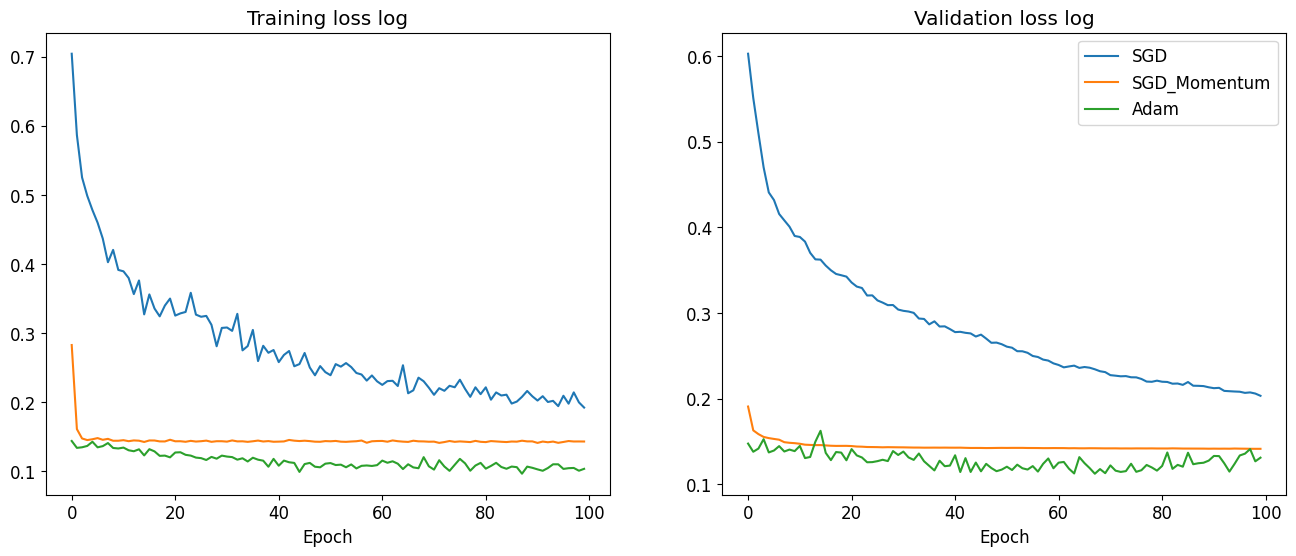

In [39]:
cand = list(optimizers.keys())

train = list(train_loss.values()); valid = list(valid_loss.values())
plot_curves(cand, 'loss', train, valid)

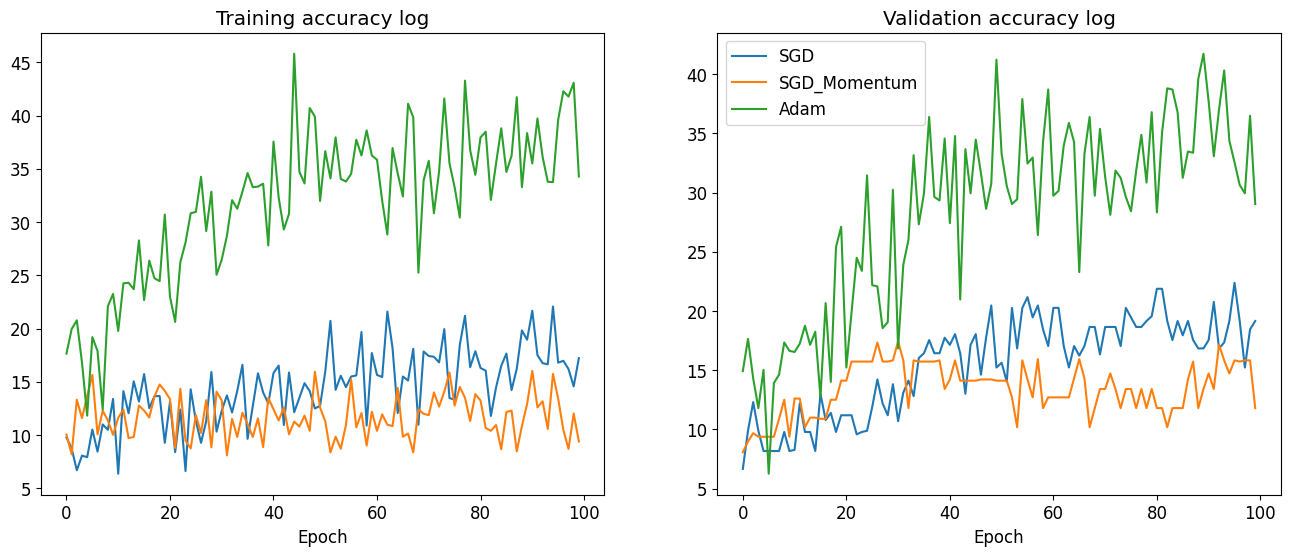

In [41]:
train = list(train_acc.values()); valid = list(valid_acc.values())
plot_curves(cand, 'accuracy', train, valid)

## Training with Best Hyperparameters


In [52]:
# Please set your hyperparameters here
BATCH_SIZE = 16
LR = 1e-4
DIM_HIDDENS = [128, 64]
REG = 1e-5
OPTIMIZER = Adam(learning_rate=LR)

In [53]:
train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = Dataloader(valid_dataset, batch_size=BATCH_SIZE)
model = Classifier(IN_DIM, OUT_DIM, DIM_HIDDENS, device=DEVICE)
model.print_param_shape()

w1 torch.Size([3072, 128])
b1 torch.Size([128])
w2 torch.Size([128, 64])
b2 torch.Size([64])
w3 torch.Size([64, 10])
b3 torch.Size([10])


Epoch 1:
[MODEL SAVED]
Training accuracy: 25.29%, loss: 0.1631
Validaion accuracy: 18.22%, loss: 0.1548
Epoch 2:
Training accuracy: 30.21%, loss: 0.1336
Validaion accuracy: 18.52%, loss: 0.1721
Epoch 3:
[MODEL SAVED]
Training accuracy: 32.06%, loss: 0.1283
Validaion accuracy: 28.26%, loss: 0.1323
Epoch 4:
Training accuracy: 33.33%, loss: 0.1247
Validaion accuracy: 25.39%, loss: 0.1408
Epoch 5:
[MODEL SAVED]
Training accuracy: 34.73%, loss: 0.1208
Validaion accuracy: 34.82%, loss: 0.1265
Epoch 6:
[MODEL SAVED]
Training accuracy: 35.50%, loss: 0.1189
Validaion accuracy: 29.87%, loss: 0.1248
Epoch 7:
Training accuracy: 31.98%, loss: 0.1207
Validaion accuracy: 29.84%, loss: 0.1275
Epoch 8:
Training accuracy: 36.02%, loss: 0.1149
Validaion accuracy: 29.48%, loss: 0.1387
Epoch 9:
Training accuracy: 37.28%, loss: 0.1127
Validaion accuracy: 25.70%, loss: 0.1367
Epoch 10:
Training accuracy: 36.70%, loss: 0.1135
Validaion accuracy: 29.11%, loss: 0.1265
Epoch 11:
Training accuracy: 37.20%, loss: 

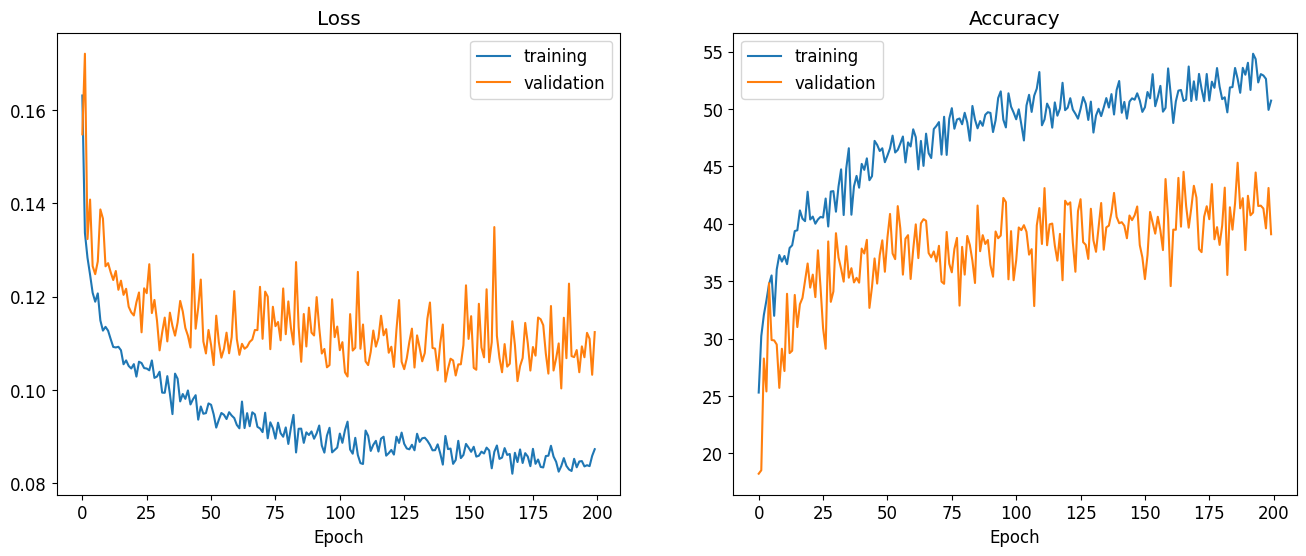

In [54]:
train_loss, train_acc, valid_loss, valid_acc = model.training(train_dataloader, valid_dataloader, optimizer=OPTIMIZER, reg_lambda=REG)
plot_result(train_loss, train_acc, valid_loss, valid_acc)

Test the model with test_dataset. <font color='red'>The test accuracy must reach at least 40%.</font>

In [55]:
test_dataloader = Dataloader(test_dataset)
model.load_model(MODEL_PATH)
model.test(test_dataloader)

Got 4363 correct prediction in 10000 test data, accuracy: 43.63%
